[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for  [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-5-nano",temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [11]:
from langgraph.graph import MessagesState
class State(MessagesState): # already has messages key
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [23]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    
    summary = state.get("summary", "")
    
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content = system_message)] + state["messages"]
    
    else:
        messages = state['messages']
        
    response = model.invoke(messages)
    return {"messages":response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [24]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is the summary of the conversation to data: {summary}\n"
            "Extend the summary by taking into account the new messages above:"
        )
    
    else:
        summary_message = "Create a summary of the conversation above:"
        
    messages = state["messages"] + [HumanMessage(content = summary_message)]
    response = model.invoke(messages)

    
    delete_messages = [RemoveMessage(id = m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [25]:
from langgraph.graph import END
from typing_extensions import Literal

def should_continue(state: State) -> Literal["summarize_conversation", END]:
    messages = state['messages']
    
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://docs.langchain.com/oss/python/langgraph/persistence) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer provides memory, allowing LangGraph to resume from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

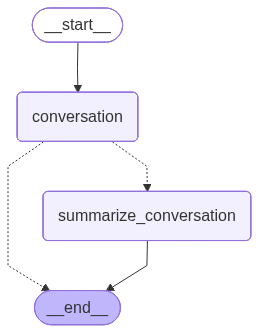

In [26]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = InMemorySaver()

graph = workflow.compile(checkpointer=InMemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))



## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [27]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Shiv")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================

Hi Shiv! Nice to meet you. What would you like to do today? I can help with:

- answering questions and explanations
- drafting emails, messages, or documents
- brainstorming ideas or planning a project
- learning about a topic or practicing a skill
- coding help or debugging
- translation or improving writing

Tell me your goal or topic, and we’ll dive in. If you’d rather just chat, I’m game for that too.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================

Your name is Shiv — you introduced yourself with that. If you’d like me to call you a nickname or something else, tell me and I’ll use it. What would you like to do today?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================

Awesome, Shiv! The 49ers are a storied franchise. Quick fun fact: they’ve won five Super Bowls (1981, 1984, 1988, 1989, 1994).

What would you like to dive into?
- Favorite era or players (e.g., Montana, Rice, Young, or current stars)
- Current roster, season outlook, or upcoming games
- Biggest rivalries and memorable moments
- Fantasy football ideas involving 49ers players
- Watching party tips or game-day traditions

Tell me which direction you want, or ask me anything specific about the team.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


In [30]:
print(len(output['messages']))

6


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [32]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [33]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


================================== Ai Message ==================================

Short answer: yes, by average annual value (AAV) he is the highest-paid defensive player.

- Nick Bosa signed a 5-year, about $170 million extension in 2023, which works out to roughly $34 million per year.
- The deal also includes a large amount guaranteed (about $122.5 million), which is among the top guarantees for a defender.

Notes:
- If you measure by AAV, he tops other defenders like Aaron Donald.
- If you’re thinking about total guaranteed money or other contract quirks, there are different ways to compare, but AAV is the common metric people use for “highest paid.”

Want me to pull up the exact figures for the latest year or compare him to other top defensive deals?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithUserError: This API key is org-scoped and requires workspace specification. Please provide 'workspace_id' parameter, or set LANGSMITH_WORKSPACE_ID environment variable.


In [34]:
graph.get_state(config).values.get("summary","")

'Here’s a concise recap of our chat so far:\n\n- Shiv introduced themselves and said they like helping with things; I outlined how I can help (questions, drafting, brainstorming, coding, etc.).\n- Shiv: They like the 49ers.\n- I shared a quick 49ers fact and suggested topics to explore (era/players, current roster, rivalries, fantasy ideas, game-day tips).\n- Shiv: They like Nick Bosa and asked if he’s the highest paid defensive player.\n- I answered: yes, by average annual value (AAV). Provided contract details: 5-year, ~$170M extension in 2023 (~$34M per year) with about $122.5M guaranteed, noted it’s among the top guarantees; mentioned caveats about different metrics (AAV vs guarantees) and offered to pull exact figures or compare to others.\n\nIf you want, I can pull the latest figures or make comparisons to other top defensive contracts.'